# **Predicting Real Estate Prices| End-to-End Machine Learning Project** 

**Objective:** Build a machine Learning Model to predict the median housing price in any block in California using available metrics. This model's output could be fed to anothe machine learning system (see fig below) along with many other signals. This downstream system will determine whether it is worth investing on a property in a given area or not.

![alt text](https://drive.google.com/uc?id=1hewsswt2cL1A-uXmKT1eWWIQTRw3CydU)

**Steps followed:**
1. Get Data
2. Exploratory data analysis to gain insights
3. Data preparation for machine learning algorithms
4. Model selection
5. Fine tuning the model 

**About the data:**

The California Housing Prices dataset from the StatLib repository is used for 
the project. This dataset was based on data from the 1990 California census. It 
is not exactly recent, but it has many qualities for learning, so would  
pretend it is recent data and go ahead.


---


This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people)


---


According to the data source, the median income attribute has been scaled and capped at 15.0001 for higher median incomes and at 0.4999 for lower median incomes. The number represents roughly tens of thousands of dollars.


---


The housing median age and median house value were also capped. Two things could be done if precise predictions are needed, 1- collect proper values for blocks whose values were capped, 2- remove  those blocks whose values were capped.

**Approach to the problem:**
1. It is clearly a typical supervised learning task since the dataset has 'Label' or output variable.
2. Because the housing prices have to be predicted, this is a ***regression*** problem
3. Because the the prediction will use mutiple features, it is a ***multiple regression*** problem
4. It is also a ***univariate regression*** problem since a single vaue will be predicted for each Block
5. There is no continueous flow of data coming in the system, there is no need to adjust to changing data rapidly, a plain batch learning should be enough

**Performance Measure**

A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

 RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}

**Download the data**

In [64]:
# Import necessary packages to import data from website and decompress the file
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [65]:
# This is a small function to load data 

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

**A quick look at the data structure**

In [66]:
# A quick look at the data
housing = load_housing_data()
print(housing.info())
print(housing.head())
print(housing.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.

There are 20,640 records in the dataset. Each record represent a block.

All attributes are numerical eacept the ***ocean_proximity*** which is categorical

207 records do not have ***total_bedrooms*** values  

In [67]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [68]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [69]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


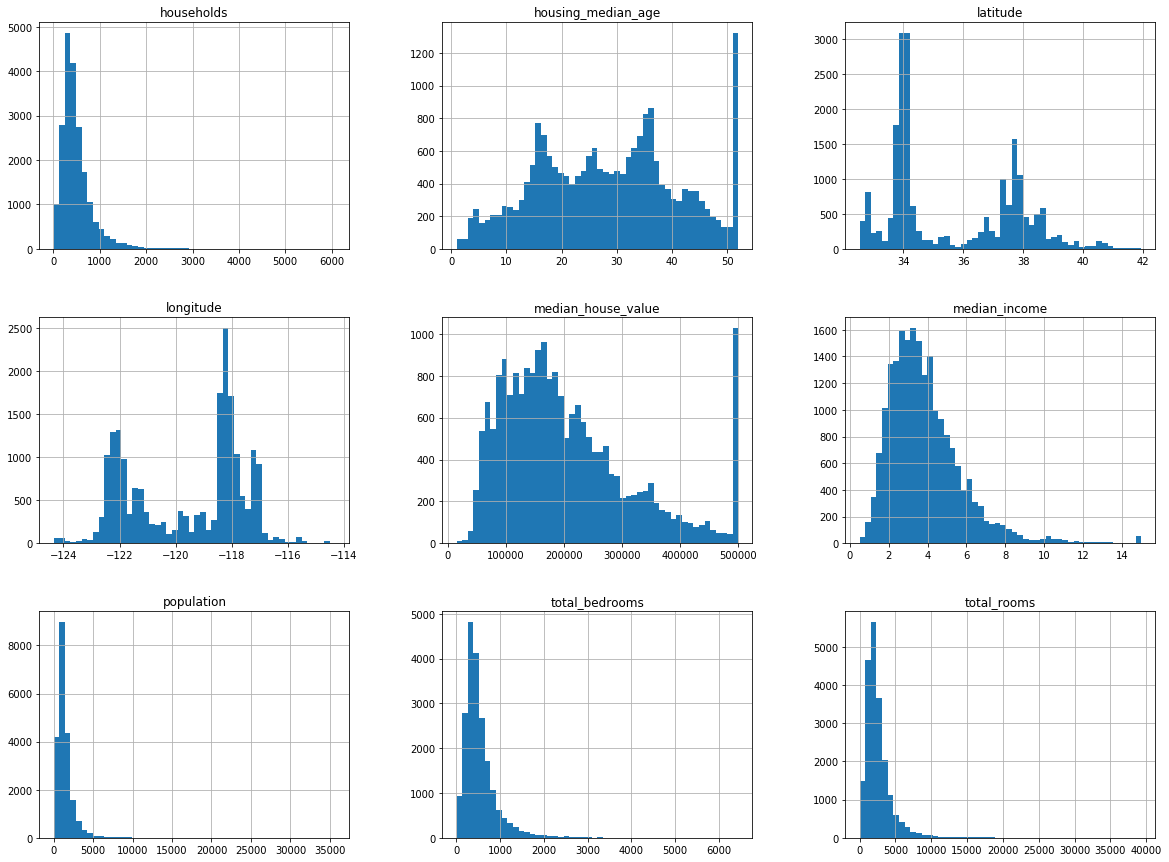

In [70]:
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,15))
plt.show();


Attributes have different scales.

Histograms are ***tail heavy***; they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. These attributes needs to be transformed later on to have more bell-shaped distribution.

**Look for Correations**

Look for correlation of each attribute with median house value

In [71]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

There is a strong correlation between median house value and median income, meanin g the house value goesw up when the median income goes up.

A small negative correlation between the latitude and the median house value can eeb seen(i.e., prices have a slight tendency to go down when you go north)

Visualize the correlation matrix

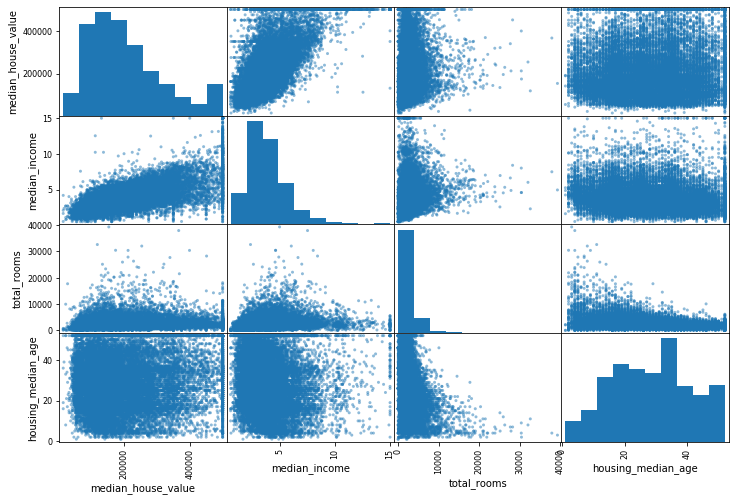

In [72]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show();

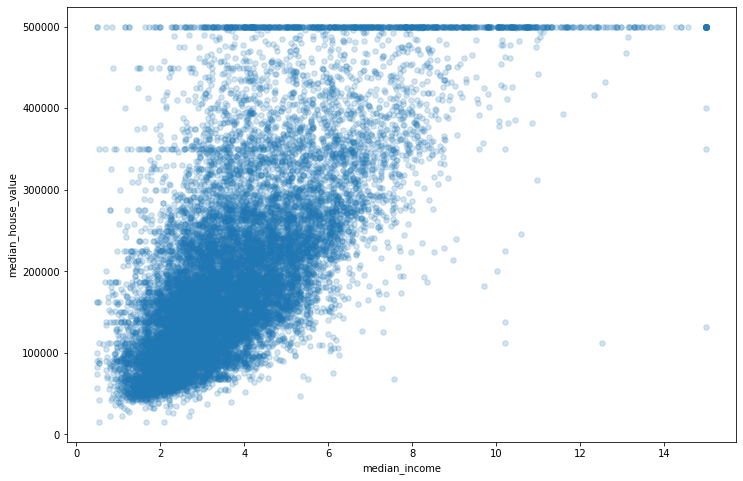

In [98]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.2, figsize = (12,8), s = 30)
plt.show();

**Create a test Dataset**

Set aside a part of data at this stage to avoid ***'data snooping bias'*** in model selection.

In [73]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.3, random_state = 42)

### **Sampling**

As the correlation matrix suggests, the median income is a very important attribute to predict median housing prices. The median income is a continueous numerical variable ranging from 0.49 to 15 (x 10000 dollars). To ensure equal representation of median income in the test dataset, the income has to be grouped into different income bands (strata) and a representative sample should be drawn for the test dataset.

As seen in the Histogram, most medicome values are clustered around 1.5 to 6, but some go beyond 6.  It is important to have a sufficient number of instances in the dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that too many strata should not be formed, and each stratum should be large enough.

In [74]:
# Create five income bands and assign each recor to the corresponding income band
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'],bins = [0.,1.5,3,4.5,6,np.inf], labels = [1,2,3,4,5])

In [75]:
housing.income_cat

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [76]:
# Check distribution of the median income across the newly created income bands
housing.income_cat.value_counts()/len(housing)*100

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64

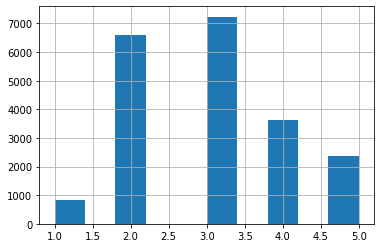

In [77]:
# Visualize the distribution of median income
housing.income_cat.hist()

In [78]:
# Stratified sampling for training and test dataset
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits =1, test_size = 0.2,random_state = 42)
for train_index, test_index in split.split(housing,housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [94]:
# Check if the distribution of median income is representative of the full dataset
strat_test_set['income_cat'].value_counts()/len(strat_test_set)*100

KeyError: 'income_cat'

The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset.

In [80]:
# drop the 'income_cat' attribute as it is redundent
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis = 1, inplace = True)

### Exploring and visualizing data to gain insights 

In [81]:
housing = strat_train_set.copy()

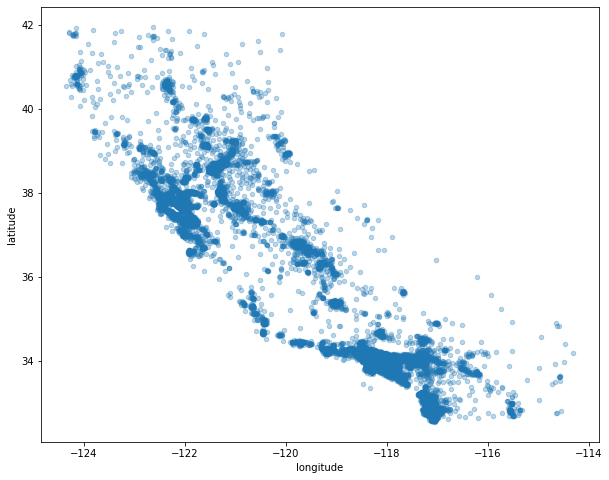

In [82]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.3, figsize = (10,8),s = 20)

The Bay Area,Los Angeles,San Diego the Central Valley are high density areas

### Visualize geographic data

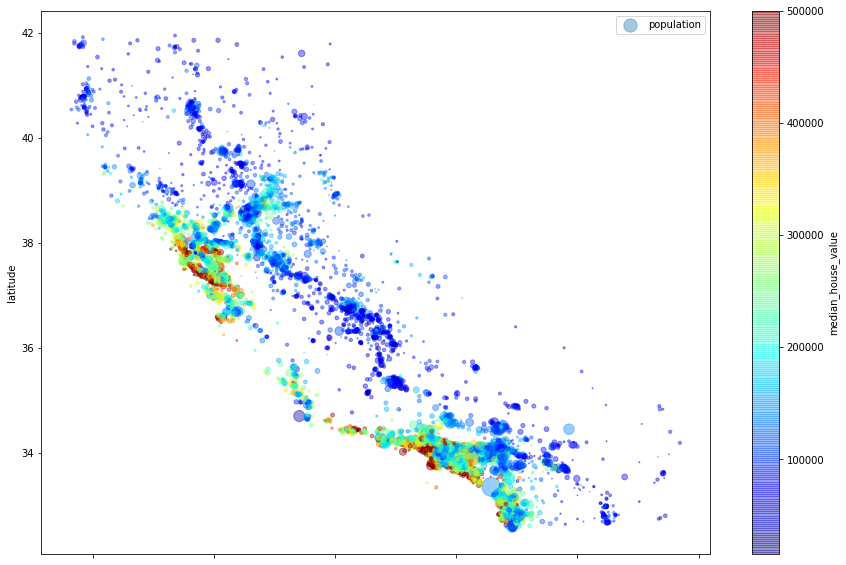

In [97]:
#Plotting population (size of the scatter points) and prices (color of the scatter points)
from matplotlib import cm
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(15,10),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.show();

This image indicates that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

### Feature Engineering

The total number of rooms in a block is not useful to predict a house price. Having number of rooms per house would be useful similarly, number of bedrooms iitself is not useful.

New attributes for number of rooms per house and number of bedrooms per room, and household size could be created using the available data.

In [89]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Looking at the correlation matrix again with new attributes

In [90]:
corr_matrix = housing.corr()

In [91]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a block—obviously the larger the houses, the more expensive they are

## Prepare the Data for Machine Learning Algorithms

In [102]:
# Seperate the predictors and labels as the transformation need not be applied to output variable
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

Most Machine Learning algorithms cannot work with missing features, These have to be treated before being fed to the algorithms. The total_bedrooms attribute has some missing values,the need to be fixed. One of the option is to replace the missing values (impute) with median of the total_bedroom attribute.

In [107]:
# replace missing values with the series' median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [106]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [108]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [110]:
# transform the training set using the 'trained' imputer
X = imputer.transform(housing_num)
# put the transformed data into data frame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling the text and categorical arrtibutes

In [112]:
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
...,...
6563,INLAND
12053,INLAND
13908,INLAND
11159,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so convert these categories from text to numbers

In [113]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [114]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This could be acheived bu creating dummies.

In [116]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when there are  categorical attributes with thousands of categories. One-hot encoding returns  a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements.

In [117]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [119]:
# a Function to add newly created attributes to the dataset
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

The scale of each attribute in the dataset is different.the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Many Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. All attributes have to be converted to same scale. 

### Transformation Pipelines

There are many data transformation steps that need to be executed in the right order. Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [122]:
# apply different transformation to different columns at once using ColumnTransformer
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs),])

housing_prepared = full_pipeline.fit_transform(housing)

## Model selection and training

### Linear Regression

In [123]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Try it out on a few instances from the training set

In [126]:
test_data = housing.iloc[:5]
test_labels = housing_labels.iloc[:5]
test_data_prepared = full_pipeline.transform(test_data)
print("Predictions:", lin_reg.predict(test_data_prepared))
print("Labels:", list(test_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!)

### Model's performance measurement

In [124]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Most Blocks’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, so this rules out the last option.

### Decision Tree Regressor

In [128]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [129]:
# Evaluate Decision Regressor
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The model has zero errors indicating a bad overfitting the data.

### Better evaluation of the model using cross validation

In [130]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
A function to dispay scores
def display_scores(scores):
  print('Scores:', scores)
  print('Mean:', scores.mean())
  print('Standard Deviation:', scores.std())

In [132]:
display_scores(tree_rmse_scores)

Scores: [68792.7182699  66352.44822184 69985.73376673 68866.41665206
 72034.68637226 75862.62026458 70798.2981453  72399.18703456
 75301.73894558 70716.36196003]
Mean: 71111.02096328439
Standard Deviation: 2779.0098188814454


A Mean of 71111 +/- 2779 is not a good either. In fact it performed worse than the LinerRegression

In [134]:
# Run scores for Liunear Regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983493


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

### Random Forest Regressor

In [137]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

C:\Users\naren\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [139]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores) 

Scores: [53047.98574045 50126.6686075  52615.76922424 55496.0135214
 51177.85280034 55029.94354963 50923.22369048 49823.26185006
 54179.33596502 52733.84835798]
Mean: 52515.39033071163
Standard Deviation: 1886.6587861812893


Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set.

### Fine Tuning the model

### Grid Search

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance

In [141]:
# Grid search to evaluate all the combinations of hyperparameter values, using cross-validation

from sklearn.model_selection import GridSearchCV
param_grid = [
              {'n_estimators':[3,10,30],'max_features': [2,4,6,8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [144]:
#best parameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [143]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [148]:
# Evaluation of Grid Search

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64070.47961924377 {'max_features': 2, 'n_estimators': 3}
55367.7072297615 {'max_features': 2, 'n_estimators': 10}
52948.05728192419 {'max_features': 2, 'n_estimators': 30}
60765.19282793371 {'max_features': 4, 'n_estimators': 3}
53315.58648645994 {'max_features': 4, 'n_estimators': 10}
50719.10885615082 {'max_features': 4, 'n_estimators': 30}
58194.29738321838 {'max_features': 6, 'n_estimators': 3}
52072.683244001644 {'max_features': 6, 'n_estimators': 10}
50047.3143326871 {'max_features': 6, 'n_estimators': 30}
58944.58063027389 {'max_features': 8, 'n_estimators': 3}
51686.77387147379 {'max_features': 8, 'n_estimators': 10}
49869.22664627754 {'max_features': 8, 'n_estimators': 30}
62051.16045259753 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54497.721036026924 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60465.88992185653 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52556.80164252435 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

Best solution is obtained by setting the max_features hyperparameter to 8, and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49,869, which is slightly better than the earlier score obtained using the default hyperparameter values (which was 52,515)

### Analyze the model and it's errors

In [149]:
# Reative importance of each attribute for estimating housing prices
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.67222446e-02, 6.70958051e-02, 4.40462854e-02, 1.52805914e-02,
       1.38025334e-02, 1.49968116e-02, 1.47954947e-02, 3.70582063e-01,
       4.04818257e-02, 1.05740189e-01, 7.32374781e-02, 6.36184682e-03,
       1.51347504e-01, 1.44996059e-04, 1.99644090e-03, 3.36788943e-03])

Importance scores and their corresponding attribute names

In [150]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.37058206303146973, 'median_income'),
 (0.1513475042566509, 'INLAND'),
 (0.10574018937812578, 'pop_per_hhold'),
 (0.0767222446299094, 'longitude'),
 (0.07323747809903673, 'bedrooms_per_room'),
 (0.06709580510679607, 'latitude'),
 (0.04404628541620156, 'housing_median_age'),
 (0.0404818257117737, 'rooms_per_hhold'),
 (0.015280591394249976, 'total_rooms'),
 (0.01499681158335099, 'population'),
 (0.01479549473426484, 'households'),
 (0.01380253344720682, 'total_bedrooms'),
 (0.006361846817135447, '<1H OCEAN'),
 (0.003367889432609932, 'NEAR OCEAN'),
 (0.001996440902221823, 'NEAR BAY'),
 (0.00014499605899631079, 'ISLAND')]

## Evaluating the system on the Test Set

In [151]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [152]:
final_rmse

47483.06339632713